In [ ]:
"""
DB WAIT
20887507

"""

%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from matplotlib import pylab as plt

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#A helper-function to setup a proper plot
def setup_plot(title, y_label='', x_label='', newfig=True):
  if newfig:
    plt.figure()
  plt.margins(*(plt.array(plt.margins())+0.05))
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)


def fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  
  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit
  
  return mn

def pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  return rn

def chirp_fsk(bitseq, spb, f_0, f_1, F, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  chirp = np.array(range(0,spb))*(df/spb) - df/2

  print(chirp)

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit

  return mn

def chirp_pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift
  chirp = np.array(range(0,spb))*(df/spb) - df/2

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*(f_1+chirp)*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*(f_0-chirp)*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  return rn


def downsample(input, len, factor):
  output = input[:len:factor]
  return output


def xnor_autocorr(x):
  N = x.shape[0]
  y = x
  rxx = np.zeros(shape = (N,), dtype = np.float32 )

  for i in range(0,N):
    #rxx[i+N-1] = np.sum( x[0:N-i]*y[i:N] )
    for n in range(0, N-i):
      if (x[n] == y[n+i]):
        rxx[i] = rxx[i] + 1

  rxx = np.insert(rxx, 0, np.flip(rxx[1:N]))
  return rxx


def xnor_xcorr(x, y):
  N = x.shape[0]
  rxx = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  r2 = np.zeros(shape = (2*N-1,), dtype = np.float32 )
  
  for i in range(0,N):
    #rxx[i+N-1] = np.sum( y[0:N-i]*x[i:N] )
    for n in range(0, N-i):
      if (y[n] == x[n+i]):
        rxx[i+N-1] = rxx[i+N-1] + 1

  for i in range(0,N):
      #rxx[N-i-1] = np.sum( x[0:N-i]*y[i:N] )
      for n in range(0, N-i):
        if (x[n] == y[n+i]):
          rxx[N-i-1] = rxx[N-i-1] + 1
  rxx[N-1] = rxx[N-1]/2

  return rxx


def envelope_xcorr(x, y, samps):
  rbb = xnor_xcorr(x, y)
  rbb = np.insert(rbb, 0, np.zeros(shape = (1, )) )
  rbb = np.append(rbb, np.zeros(shape = (1, )) )

  rbb_l = np.zeros(shape = (rbb.shape[0]*samps-1))
  rbb_l = np.zeros(shape = ( (rbb.shape[0]-1)*samps - 1, )  )

  for k in range(0, rbb.shape[0]-1):
    grad = (rbb[k+1] - rbb[k])/2
    start = k*samps
    for i in range(1, samps+1):
      rbb_l[start + i - 2] = grad*i + rbb_l[start - 2]

  return rbb_l


def show_corr_outs(bitseq, f0, f1, fs, samps, dsamp, delta_f):
  print(bitseq.shape[0])
  rbb = np.correlate(bitseq, bitseq, mode = "full")

  setup_plot("1/0 Binary xCorr")
  plt.plot(rbb)
  plt.show()

  rrr = xnor_autocorr(bitseq)
  setup_plot("CUSTOM Binary xCorr")
  plt.plot(rrr)
  plt.show()

  #STANDARD FSK
  tx = fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs)
  tx = downsample(tx, bitseq.shape[0]*samps, dsamp)

  rx = pollute(bitseq=bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0)
  rx = downsample(rx, bitseq.shape[0]*samps, dsamp)

  rtr = np.correlate(rx, tx, mode = "full")
  setup_plot("Standard FSK Modulated xCorr")
  plt.plot(rtr)
  plt.show()

  #CHIRPED FSK
  ctx = chirp_fsk(bitseq = bitseq, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f*4)
  ctx = downsample(ctx, bitseq.shape[0]*samps, dsamp)

  crx = chirp_pollute(bitseq = bitseq, len_f = 0, len_b = 0, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift = 0, noise_stddev = 0, df = delta_f*4)
  crx = downsample(crx, bitseq.shape[0]*samps, dsamp)

  crtr = np.correlate(crx, ctx, mode = "full")
  setup_plot("Chirped FSK ModulatedxCorr")
  plt.plot(crtr)
  plt.show()


def cdma_fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  cnt0 = 0
  cnt1 = 0

  for i in range(0, nb):

    if (bitseq[i] == 1):
      fi = f_1[ cnt1 % f_1.shape[0] ]
      bit = np.sin(2*fi*np.pi*num*T)
      cnt1 = cnt1 + 1

    if (bitseq[i] == 0):
      fz = f_0[ cnt0 % f_0.shape[0] ]
      bit = np.sin(2*fz*np.pi*num*T)
      cnt0 = cnt0 + 1

    mn[i*spb:(i+1)*spb] = bit

  return mn


def cdma_symbols_conv( bitseq, f_0, f_1):
  len = bitseq.shape[0]
  cdma_symbols = np.zeros( shape = (len, ) ) 
  cnt0 = 0
  cnt1 = 0

  for i in range(0, len):

    if bitseq[i] == 0:
      cdma_symbols[i] = f_0[ cnt0 % f_0.shape[0] ]
      cnt0 = cnt0 + 1

    if bitseq[i] == 1:
      cdma_symbols[i] = f_1[ cnt1 % f_1.shape[0] ]
      cnt1 = cnt1 + 1

  return cdma_symbols


def cdma_chirp_fsk(bitseq, spb, f_0, f_1, F, df):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  chirp = np.array(range(0,spb))*(df/spb) - df/2

  print(chirp[0], chirp[spb-1])
  cnt0 = 0
  cnt1 = 0

  for i in range(0, nb):

    if (bitseq[i] == 1):
      fi = f_1[ cnt1 % f_1.shape[0] ]
      bit = np.sin(2*(fi+chirp)*np.pi*num*T)
      cnt1 = cnt1 + 1

    if (bitseq[i] == 0):
      fz = f_0[ cnt0 % f_0.shape[0] ]
      bit = np.sin(2*(fz-chirp)*np.pi*num*T)
      cnt0 = cnt0 + 1

    mn[i*spb:(i+1)*spb] = bit

  return mn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding
 
def vec_bin_array(arr, m):
    """
    Arguments: 
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        ret[...,bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret 

#Initialize Variables

In [ ]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 1
delta_f = n/(2*Tb)
print(delta_f)

#f1 = delta_f*10
f1 = delta_f*88
f0 = delta_f*64
print(f0, f1)

bw_ch = 4*delta_f

sep_fh = 8*delta_f

fi = np.array([f1-sep_fh, f1])
fz = np.array([f0, f0+sep_fh])
print(fi, fz)

dsamp = 2
blocks = 3
L = 2048
N = L*2
print(dsamp, blocks, L, N)

882
25.0
1600.0 2200.0
[2000. 2200.] [1600. 1800.]
2 3 2048 4096


#TEST MODULATED SIGNAL

-50.0 49.886621315192755


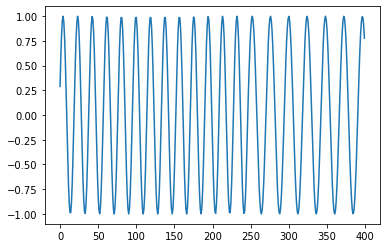

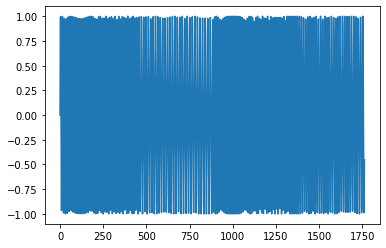

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


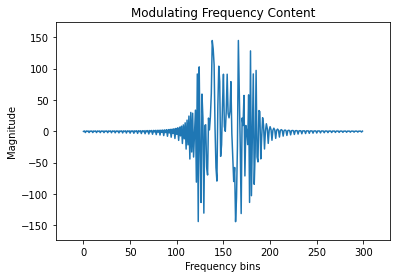

In [ ]:
bits = np.array( [1,0,1,0] )

ctx = cdma_chirp_fsk( bitseq = bits, spb = 882, f_0 = fz, f_1 = fi, F = int(fs),  df = bw_ch )
#ctx = cdma_fsk( bitseq = bits, spb = 882, f_0 = fz, f_1 = fi, F = int(fs) )
plt.plot(ctx[2400:2800])
plt.show()

ctx = downsample(ctx, bits.shape[0]*int(fs*0.02), 2)
plt.plot(ctx)
plt.show()

setup_plot('Modulating Frequency Content', 'Magnitude', 'Frequency bins')
fw_axis = np.linspace(0, 1, len(ctx), False)

plt.plot(np.fft.fft(ctx)[0:300])
plt.show()


#Optimum 12-bit Binary Codes



1.   Initialize and define
2.   Populate matrix (integer;  peak-to-sidelobe ratio;  binary character;  XNOR correlation)
3.   Sort by sidelobe ratio (SLR)
4.   Filter standard FSK modulated entries which have a cross-correlation > 8 matches
5.   Filter FHSS FSK modulated entries which have a cross-correlation > 8 matches
6.   Filter FHSS FSK modulated entries which have a cross-correlation > 5 matches



**Intitalize Structure**

In [ ]:
BITS = 12
MAX = 2**BITS
vals = np.array(range(0, MAX))
print(vals)

num = 0
slr = num+1
bit_begin = slr+1
bit_end = bit_begin+BITS
rxx_begin = bit_end+1
rxx_end = rxx_begin + 2*BITS - 1  

print(num, slr, bit_begin, bit_end, rxx_begin, rxx_end)

[   0    1    2 ... 4093 4094 4095]
0 1 2 14 15 38


**Populate Matrix + Sort by SLR**

In [ ]:
A = np.zeros( shape = (MAX, rxx_end))

A[:,num] = np.array(range(0, MAX))

A[:, bit_begin:bit_end] = vec_bin_array(arr = vals, m = BITS)

for i in vals:
  bin_seq = A[i, bit_begin:bit_end]
  bin_rxx = xnor_autocorr(bin_seq)
  A[i, rxx_begin:rxx_end] = bin_rxx

  max_lobe = bin_rxx[0]
  for k in range(1, BITS-1):
      if bin_rxx[k] > max_lobe:
        max_lobe = bin_rxx[k]

  A[i, slr] =  max_lobe/bin_rxx[BITS-1]

A = A[A[:,slr].argsort()]
print(A[:, num:slr+1])
print(A.shape)

[[3.24400000e+03 3.33333343e-01]
 [8.51000000e+02 3.33333343e-01]
 [3.17800000e+03 4.16666657e-01]
 ...
 [2.04700000e+03 8.33333313e-01]
 [0.00000000e+00 9.16666687e-01]
 [4.09500000e+03 9.16666687e-01]]
(4096, 38)


**FSK xCorr of Codes + Filter xCorr_max > 5**

In [ ]:
B = A

xcor_thresh = 5
dels = []

bdel = np.zeros( shape = (B.shape[0],) )

for i in range(0, B.shape[0]):
  if bdel[i] == 0:
    
    for k in range(i+1, B.shape[0]):
      if bdel[k] == 0:
        bitseq1 = B[i, bit_begin:bit_end]
        bitseq2 = B[k, bit_begin:bit_end]
        rik = xnor_xcorr(bitseq1, bitseq2)
        rik_max = np.max(rik)
        if ( rik_max > xcor_thresh):
          bdel[k] = 1
          dels.append(k)

A_xcor8 = np.delete(B, obj = np.array(dels), axis = 0)
print(A_xcor8.shape[0])

print(A_xcor8[:, bit_begin:bit_end])

1
[[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]]


**Setup**

In [ ]:
BITS = 12
MAX = 2**BITS
vals = np.array(range(0, MAX))
print(vals)

num = 0
slr = num+1
bit_begin = slr+1
bit_end = bit_begin+BITS
rxx_begin = bit_end+1
rxx_end = rxx_begin + 2*BITS - 1  

print(num, slr, bit_begin, bit_end, rxx_begin, rxx_end)

A = np.zeros( shape = (MAX, rxx_end))
A[:,num] = np.array(range(0, MAX))
A[:, bit_begin:bit_end] = vec_bin_array(arr = vals, m = BITS)

[   0    1    2 ... 4093 4094 4095]
0 1 2 14 15 38


In [ ]:
for i in vals:
  bin_seq = A[i, bit_begin:bit_end]
  cdma_seq = cdma_symbols_conv(bin_seq, fz, fi)
  cdma_rxx = xnor_autocorr(cdma_seq)
  A[i, rxx_begin:rxx_end] = cdma_rxx

  max_lobe = cdma_rxx[0]
  for k in range(1, BITS-1):
      if cdma_rxx[k] > max_lobe:
        max_lobe = cdma_rxx[k]

  A[i, slr] =  max_lobe/cdma_rxx[BITS-1]

A = A[A[:,slr].argsort()]
print(A[:, num:slr+1])

[[1.41300000e+03 1.66666672e-01]
 [2.75700000e+03 1.66666672e-01]
 [3.71000000e+02 1.66666672e-01]
 ...
 [2.04700000e+03 7.50000000e-01]
 [0.00000000e+00 8.33333313e-01]
 [4.09500000e+03 8.33333313e-01]]


**FHSS FSK xCorr of Codes + Filter xCorr_max > 5**

In [ ]:
xcor_thresh = 5
dels = []

bdel = np.zeros( shape = (A.shape[0],) )

for i in range(0, A.shape[0]):
  if bdel[i] == 0:

    bitseq1 = A[i, bit_begin:bit_end]
    fhss_seq1 = cdma_symbols_conv( bitseq1, fi, fz ) 

    for k in range(i+1, A.shape[0]):
      if bdel[k] == 0:
        
        bitseq2 = A[k, bit_begin:bit_end]
        fhss_seq2 = cdma_symbols_conv( bitseq2, fi, fz )
        
        rik = xnor_xcorr(fhss_seq1, fhss_seq2)
        rik_max = np.max(rik)
        if ( rik_max > xcor_thresh):
          bdel[k] = 1
          dels.append(k)

A_xcor5 = np.delete(A, obj = np.array(dels), axis = 0)

print(A_xcor5.shape[0])

print(A_xcor5[:, num])

fhss_codes12_new = A_xcor5[:, bit_begin:bit_end]

print(fhss_codes12_new)

13
[1413. 2757. 3018. 1575. 1290.  889. 3724. 1082. 2481. 2676. 1239. 2399.
  994.]
[[0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]]


In [ ]:
for k in range(0, fhss_codes12_new.shape[0]):
  fh = cdma_symbols_conv(fhss_codes12_new[k], fz, fi)
  print(fh)


[1600. 2000. 1800. 2200. 2000. 1600. 1800. 1600. 1800. 2200. 1600. 2000.]
[2000. 1600. 2200. 1800. 2000. 2200. 1600. 1800. 1600. 2000. 1800. 2200.]
[2000. 1600. 2200. 2000. 2200. 2000. 1800. 1600. 2200. 1800. 2000. 1600.]
[1600. 2000. 2200. 1800. 1600. 1800. 2000. 1600. 1800. 2200. 2000. 2200.]
[1600. 2000. 1800. 2200. 1600. 1800. 1600. 1800. 2000. 1600. 2200. 1800.]
[1600. 1800. 2000. 2200. 1600. 2000. 2200. 2000. 2200. 1800. 1600. 2000.]
[2000. 2200. 2000. 1600. 2200. 1800. 1600. 1800. 2000. 2200. 1600. 1800.]
[1600. 2000. 1800. 1600. 1800. 1600. 2200. 2000. 2200. 1800. 2000. 1600.]
[2000. 1600. 1800. 2200. 2000. 1600. 2200. 2000. 1800. 1600. 1800. 2200.]
[2000. 1600. 2200. 1800. 1600. 2000. 2200. 2000. 1800. 2200. 1600. 1800.]
[1600. 2000. 1800. 1600. 2200. 2000. 1800. 2200. 1600. 2000. 2200. 2000.]
[2000. 1600. 1800. 2200. 1600. 2000. 1800. 2200. 2000. 2200. 2000. 2200.]
[1600. 1800. 2000. 2200. 2000. 2200. 2000. 1600. 1800. 1600. 2200. 1800.]


In [ ]:
fhss_codes12 = np.array([
 [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,],
 [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,],
 [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,],
 [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,],
 [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,],
 [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,],
 [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,],
 [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,],
 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,],
 [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,],
 [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,],
 [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,],
 ])

**Autocorrelation of Remaining Codes**

Integer Number:  1413.0
Binary Number:  [0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
-50.0 49.886621315192755


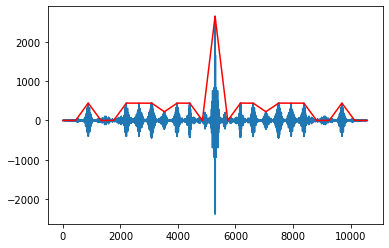

Integer Number:  2757.0
Binary Number:  [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
-50.0 49.886621315192755


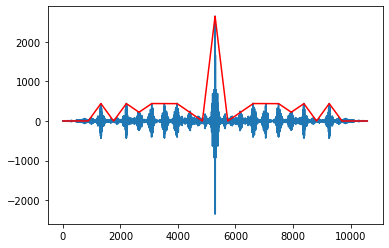

Integer Number:  3018.0
Binary Number:  [1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.]
-50.0 49.886621315192755


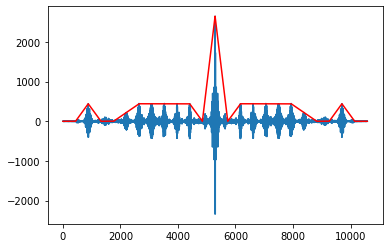

Integer Number:  1575.0
Binary Number:  [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
-50.0 49.886621315192755


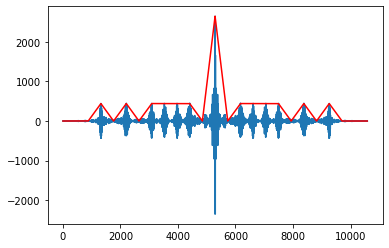

Integer Number:  1290.0
Binary Number:  [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
-50.0 49.886621315192755


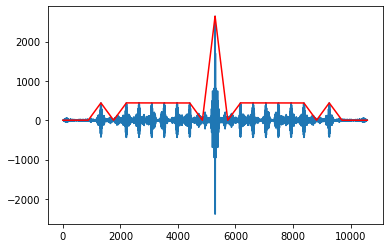

Integer Number:  889.0
Binary Number:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]
-50.0 49.886621315192755


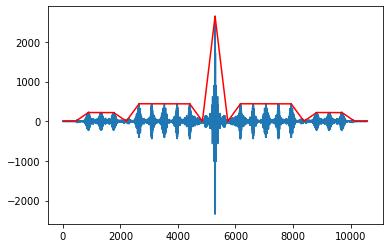

Integer Number:  3724.0
Binary Number:  [1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
-50.0 49.886621315192755


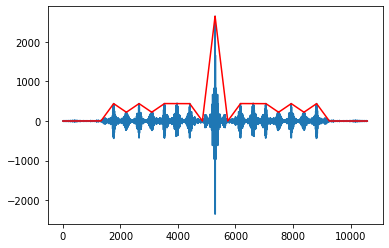

Integer Number:  1082.0
Binary Number:  [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
-50.0 49.886621315192755


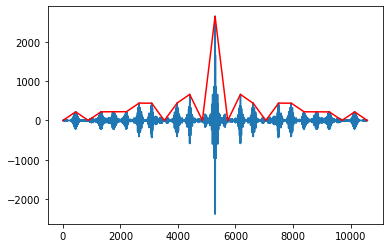

Integer Number:  2481.0
Binary Number:  [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
-50.0 49.886621315192755


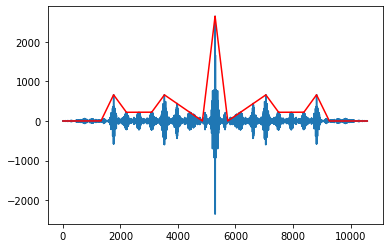

Integer Number:  2676.0
Binary Number:  [1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
-50.0 49.886621315192755


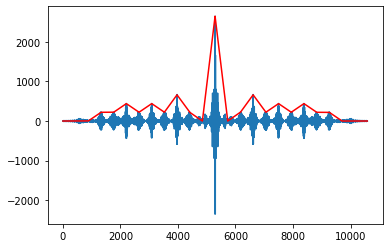

Integer Number:  1239.0
Binary Number:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
-50.0 49.886621315192755


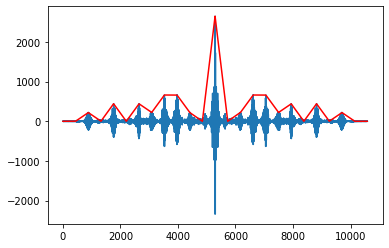

Integer Number:  2399.0
Binary Number:  [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
-50.0 49.886621315192755


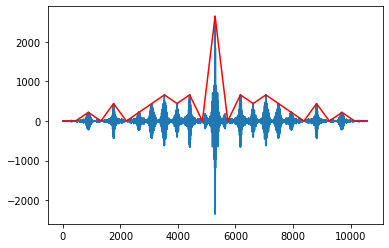

Integer Number:  994.0
Binary Number:  [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
-50.0 49.886621315192755


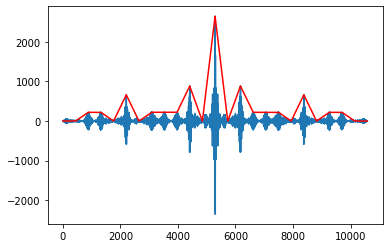

[1600. 1800.] [2000. 2200.]


In [ ]:
for i in range (0, A_xcor5.shape[0]):
  print("Integer Number: ", A_xcor5[ i, num ] )
  print("Binary Number: ", A_xcor5[ i, bit_begin : bit_end ] )

  ctx = cdma_chirp_fsk( bitseq = A_xcor5[ i, bit_begin : bit_end ], spb = int(44100*0.02), f_0 = fz, f_1 = fi, F = fs,  df = delta_f*4 )
  ctx = downsample(ctx,  A_xcor5[ i, bit_begin : bit_end ].shape[0]*int(44100*0.02), 2)
  crtt = np.correlate( ctx, ctx, mode="full")

  fhss_mod = cdma_symbols_conv( A_xcor5[ i, bit_begin : bit_end ] , fz, fi )
  rii = envelope_xcorr( fhss_mod , fhss_mod, int(samps/2) )

  plt.plot( crtt )
  plt.plot(  rii  , 'r' )
  plt.show()

print(fz, fi)

Number of Codes:  13
Code Index:  6
-50.0 49.94331065759637

###########################################################

Integer Number:  1413.0
Binary Number:  [0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
-50.0 49.94331065759637


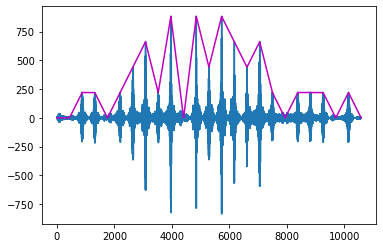


###########################################################

Integer Number:  2757.0
Binary Number:  [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
-50.0 49.94331065759637


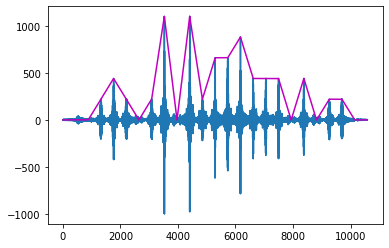


###########################################################

Integer Number:  3018.0
Binary Number:  [1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.]
-50.0 49.94331065759637


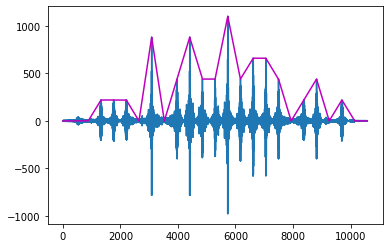


###########################################################

Integer Number:  1575.0
Binary Number:  [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
-50.0 49.94331065759637


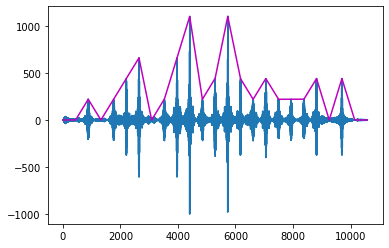


###########################################################

Integer Number:  1290.0
Binary Number:  [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
-50.0 49.94331065759637


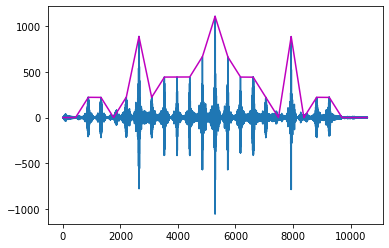


###########################################################

Integer Number:  889.0
Binary Number:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]
-50.0 49.94331065759637


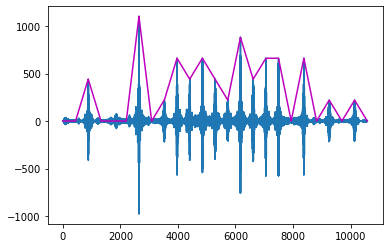


###########################################################

Integer Number:  3724.0
Binary Number:  [1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
-50.0 49.94331065759637


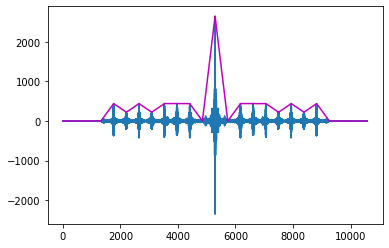


###########################################################

Integer Number:  1082.0
Binary Number:  [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
-50.0 49.94331065759637


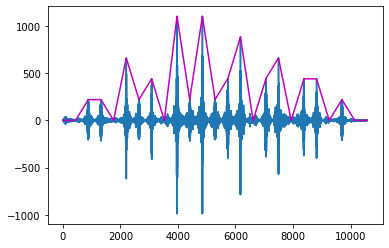


###########################################################

Integer Number:  2481.0
Binary Number:  [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
-50.0 49.94331065759637


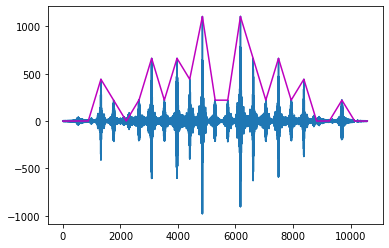


###########################################################

Integer Number:  2676.0
Binary Number:  [1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
-50.0 49.94331065759637


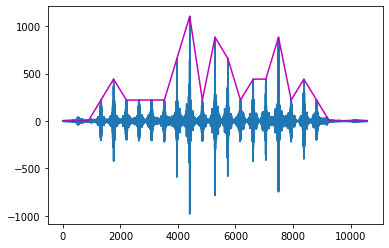


###########################################################

Integer Number:  1239.0
Binary Number:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
-50.0 49.94331065759637


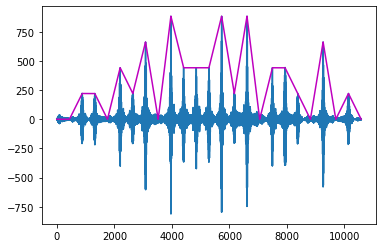


###########################################################

Integer Number:  2399.0
Binary Number:  [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
-50.0 49.94331065759637


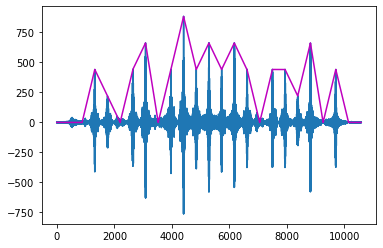


###########################################################

Integer Number:  994.0
Binary Number:  [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
-50.0 49.94331065759637


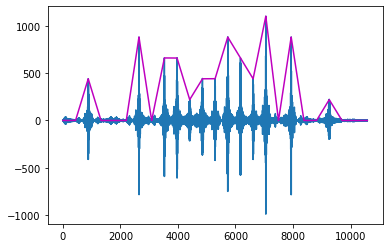

In [ ]:
code_num = np.random.randint(A_xcor5.shape[0])
print( "Number of Codes: ", A_xcor5.shape[0] )
print( "Code Index: ", code_num )

fhss_mod_code = cdma_symbols_conv( A_xcor5[ code_num , bit_begin : bit_end ] , fz, fi )

ctx = cdma_chirp_fsk( bitseq = A_xcor5[ code_num, bit_begin : bit_end ], spb = int(44100*0.04), f_0 = fz, f_1 = fi, F = fs,  df = delta_f*4 )
ctx = downsample(ctx, fhss_mod_code.shape[0]*int(44100*0.04), 4)

for i in range (0, A_xcor5.shape[0]):
  print()
  print("###########################################################")
  print()
  print("Integer Number: ", A_xcor5[ i, num ] )
  print("Binary Number: ", A_xcor5[ i, bit_begin : bit_end ] )

  crx = cdma_chirp_fsk( bitseq = A_xcor5[ i, bit_begin : bit_end ], spb = int(44100*0.04), f_0 = fz, f_1 = fi, F = fs,  df = delta_f*4 )
  crx = downsample(crx, A_xcor5.shape[0]*int(44100*0.04), 4)

  crtr = np.correlate( crx, ctx, mode="full")

  fhss_mod_comp = cdma_symbols_conv( A_xcor5[ i, bit_begin : bit_end ] , fz, fi )
  rii = envelope_xcorr( fhss_mod_comp , fhss_mod_code, int(samps/2) )

  plt.plot( crtr )
  plt.plot( rii, 'm' )
  plt.show()

#Comparison of FSK, chirped FSK, FHSS FSK, and chirped FHSS FSK 

**FSK w/ envelope**

1600.0 2200.0
0
[0 1 0 1 1 0 0 0 0 1 0 1]


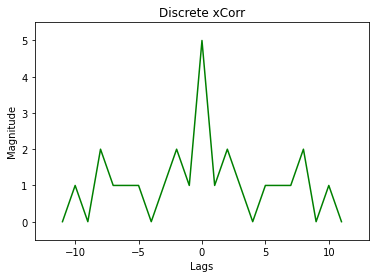

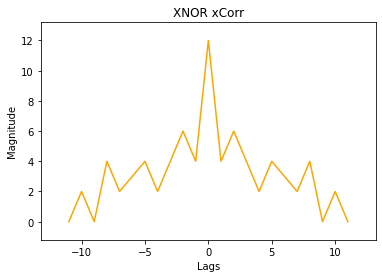

In [ ]:
print(f0,f1)
code_num = 0
print(code_num)
bitseq = fhss_codes12[code_num]
print(bitseq)

rbb = np.correlate(bitseq,bitseq, mode = 'full')

xnor_rbb = xnor_xcorr(bitseq,bitseq)

lags = np.array(range(-(bitseq.shape[0]-1), bitseq.shape[0]))

setup_plot("Discrete xCorr", "Magnitude", "Lags")
plt.plot(lags, rbb, 'g')
plt.savefig("discrete_xcorr")
plt.show()

setup_plot("XNOR xCorr", "Magnitude", "Lags")
plt.plot(lags, xnor_rbb, color='orange')
plt.savefig("xnor_xcorr")
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


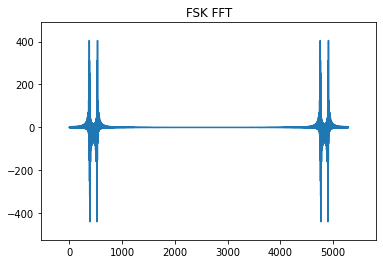

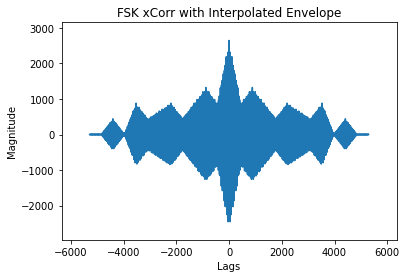

In [ ]:
ctx = fsk(bitseq = bitseq, spb = int(44100*0.02), f_0 = f0, f_1 = f1, F = fs)
ctx = downsample(ctx, bitseq.shape[0]*int(44100*0.02), 2)

rbb_env = envelope_xcorr( bitseq, bitseq, int(samps/2) )  

crtr = np.correlate(ctx, ctx, mode = "full")

setup_plot("FSK FFT")
plt.plot(np.fft.fft(ctx))
plt.show()

lags = np.array(range(-(ctx.shape[0]-1), ctx.shape[0]))

setup_plot("FSK xCorr with Interpolated Envelope", "Magnitude", "Lags")
plt.plot(lags, crtr)
#plt.plot(lags, rbb_env)
plt.savefig("fsk_xcorr")
plt.show()

**Chirped FSK w/ envelope**

[-50.         -49.94331066 -49.88662132 ...  49.82993197  49.88662132
  49.94331066]


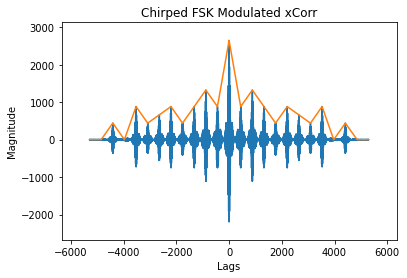

In [ ]:
ctx = chirp_fsk(bitseq = bitseq, spb = int(44100*0.04), f_0 = f0, f_1 = f1, F = fs,  df = bw_ch)
ctx = downsample(ctx, bitseq.shape[0]*int(44100*0.04), 4)

"""ctx = fsk(bitseq = bitseq, spb = int(44100*0.04), f_0 = 200, f_1 = 400, F = fs)
ctx = downsample(ctx, bitseq.shape[0]*int(44100*0.04), 4)"""

rbb_env = envelope_xcorr( bitseq, bitseq, int(samps/2) )  

crtr = np.correlate(ctx, ctx, mode = "full")

lags = np.array(range(-(ctx.shape[0]-1), ctx.shape[0]))

setup_plot("Chirped FSK Modulated xCorr", "Magnitude", "Lags")
plt.plot(lags, crtr)
plt.plot(lags, rbb_env)
plt.savefig("chirp_fsk_xcorr_env")
plt.show()

**FHSS FSK w/ envelope**

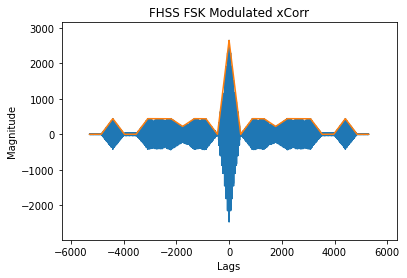

In [ ]:
fhss_code = cdma_symbols_conv(bitseq, fz, fi)

ctx = cdma_fsk( bitseq = bitseq, spb = int(44100*0.04), f_0 = fz, f_1 = fi, F = fs)
ctx = downsample(ctx, bitseq.shape[0]*int(44100*0.04), 4)

rbb_env = envelope_xcorr( fhss_code, fhss_code, int(samps/2) )  

crtr = np.correlate(ctx, ctx, mode = "full")

lags = np.array(range(-(ctx.shape[0]-1), ctx.shape[0]))

setup_plot("FHSS FSK Modulated xCorr", "Magnitude", "Lags")
plt.plot(lags, crtr)
plt.plot(lags, rbb_env)
plt.savefig("fhss_fsk_xcorr_env")
plt.show()

**Chirped FHSS FSK w/ envelope**

-50.0 49.94331065759637


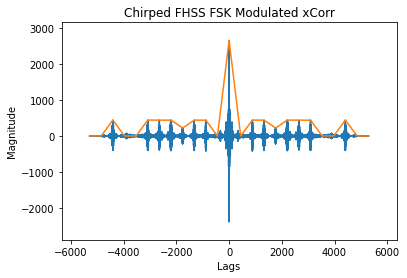

In [ ]:
fhss_code = cdma_symbols_conv(bitseq, fz, fi)

ctx = cdma_chirp_fsk( bitseq = bitseq, spb = int(44100*0.04), f_0 = fz, f_1 = fi, F = fs,  df = delta_f*4 )
ctx = downsample(ctx, bitseq.shape[0]*int(44100*0.04), 4)

rbb_env = envelope_xcorr( fhss_code, fhss_code, int(samps/2) )  

crtr = np.correlate(ctx, ctx, mode = "full")

lags = np.array(range(-(ctx.shape[0]-1), ctx.shape[0]))

setup_plot("Chirped FHSS FSK Modulated xCorr", "Magnitude", "Lags")
plt.plot(lags, crtr)
plt.plot(lags, rbb_env)
plt.savefig("chirp_fhss_fsk_xcorr_env")
plt.show()

#Maximum of FSK Autocorrelation

*For N-bit message and L samples/bit*

**Result:**

  rxx_max = N*L/2

[-12.5        -12.47165533 -12.44331066 -12.41496599 -12.38662132
 -12.35827664 -12.32993197 -12.3015873  -12.27324263 -12.24489796
 -12.21655329 -12.18820862 -12.15986395 -12.13151927 -12.1031746
 -12.07482993 -12.04648526 -12.01814059 -11.98979592 -11.96145125
 -11.93310658 -11.9047619  -11.87641723 -11.84807256 -11.81972789
 -11.79138322 -11.76303855 -11.73469388 -11.70634921 -11.67800454
 -11.64965986 -11.62131519 -11.59297052 -11.56462585 -11.53628118
 -11.50793651 -11.47959184 -11.45124717 -11.42290249 -11.39455782
 -11.36621315 -11.33786848 -11.30952381 -11.28117914 -11.25283447
 -11.2244898  -11.19614512 -11.16780045 -11.13945578 -11.11111111
 -11.08276644 -11.05442177 -11.0260771  -10.99773243 -10.96938776
 -10.94104308 -10.91269841 -10.88435374 -10.85600907 -10.8276644
 -10.79931973 -10.77097506 -10.74263039 -10.71428571 -10.68594104
 -10.65759637 -10.6292517  -10.60090703 -10.57256236 -10.54421769
 -10.51587302 -10.48752834 -10.45918367 -10.430839   -10.40249433
 -10.3741496

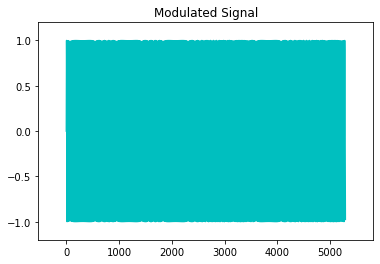

(10583,)


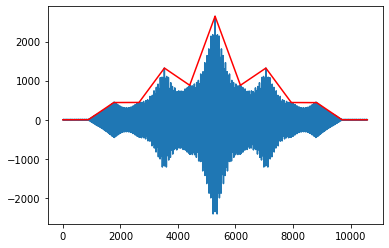

"plt.plot(tx**2, 'g')\nplt.show()\nmax = np.sum(tx**2)\nprint(max)"

In [ ]:
bits = np.array([1,1,1,0,1,0])

tx = chirp_fsk(bitseq = bits, spb = samps, f_0 = f0, f_1 = f1, F = fs, df = delta_f)
setup_plot("Modulated Signal")
plt.plot(tx, 'c')
plt.show()

rbb_l = envelope_xcorr( bits, bits, samps )

rtt = np.correlate(tx, tx, mode ="full")
print(rtt.shape)
plt.plot(rtt)

plt.plot(rbb_l, 'r')

plt.show()
"""plt.plot(tx**2, 'g')
plt.show()
max = np.sum(tx**2)
print(max)"""

#FHSS simple modulated signal

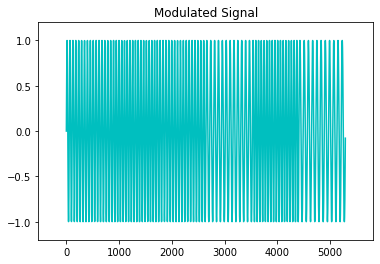

2646.0


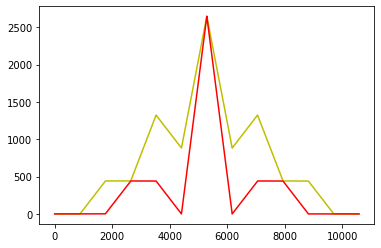

2646.0000000000005


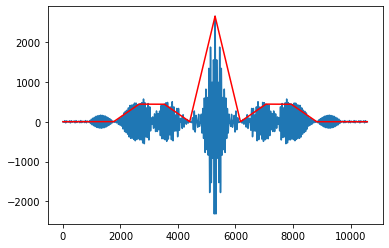

"plt.plot(tx**2, 'g')\nplt.show()\nmax = np.sum(tx**2)\nprint(max)"

In [ ]:
bits = np.array([1,1,1,0,1,0])

fi = np.array([800, 800+delta_f*2])
fz = np.array([600, 600-delta_f*2])


tx = cdma_fsk(bitseq = bits, spb = samps, f_0 = fz, f_1 = fi, F = fs)
#tx = cdma_chirp_fsk(bitseq = bits, spb = samps, f_0 = fz, f_1 = fi, F = fs, df = delta_f)
setup_plot("Modulated Signal")
plt.plot(tx, 'c')
plt.show()


rbb_l = envelope_xcorr( bits, bits, samps )
plt.plot(rbb_l, 'y')


fhss_bits = cdma_symbols_conv( bits, fi, fz )
#rbbfhss = xnor_xcorr( fhss_bits, fhss_bits )
rbbfhss = envelope_xcorr( fhss_bits, fhss_bits, samps )
print(np.max(rbbfhss))
plt.plot(rbbfhss, 'r')
plt.show()


rtt = np.correlate(tx, tx, mode ="full")
print(rtt[samps*bits.shape[0]-1])


plt.plot(rtt)
plt.plot(rbbfhss, 'r')

plt.show()


"""plt.plot(tx**2, 'g')
plt.show()
max = np.sum(tx**2)
print(max)"""

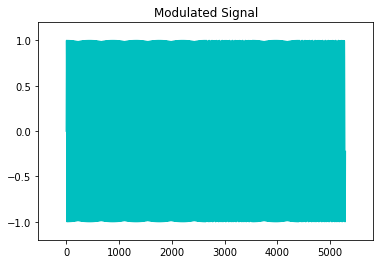

2646.0


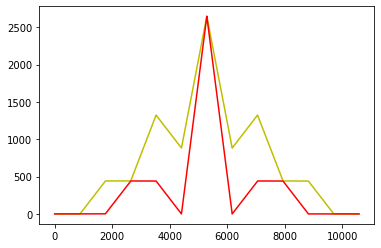

2645.999999999999


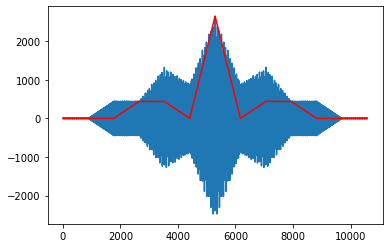

"plt.plot(tx**2, 'g')\nplt.show()\nmax = np.sum(tx**2)\nprint(max)"

In [ ]:
bits = np.array([1,1,1,0,1,0])

fi = np.array([800, 800+delta_f*2])
fz = np.array([600, 600-delta_f*2])


tx = fsk(bitseq = bits, spb = samps, f_0 = f0, f_1 = f1, F = fs)
#tx = cdma_chirp_fsk(bitseq = bits, spb = samps, f_0 = fz, f_1 = fi, F = fs, df = delta_f)
setup_plot("Modulated Signal")
plt.plot(tx, 'c')
plt.show()


rbb_l = envelope_xcorr( bits, bits, samps )
plt.plot(rbb_l, 'y')


fhss_bits = cdma_symbols_conv( bits, fi, fz )
#rbbfhss = xnor_xcorr( fhss_bits, fhss_bits )
rbbfhss = envelope_xcorr( fhss_bits, fhss_bits, samps )
print(np.max(rbbfhss))
plt.plot(rbbfhss, 'r')
plt.show()


rtt = np.correlate(tx, tx, mode ="full")
print(rtt[samps*bits.shape[0]-1])


plt.plot(rtt)
plt.plot(rbbfhss, 'r')

plt.show()


"""plt.plot(tx**2, 'g')
plt.show()
max = np.sum(tx**2)
print(max)"""

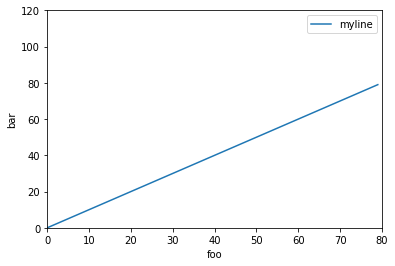

In [ ]:
plt.plot(range(80))
plt.xlabel('foo')
plt.ylabel('bar')
plt.legend(['myline'])
plt.axis([0, 80, 0, 120])
plt.savefig('sample.pdf')